# Cora Classification with SVGP

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import scipy.special
from sklearn.metrics import accuracy_score
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)
import pandas as pd
import pickle

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from cora_utils.preprocessing import load_PEMS, load_cora

In [ ]:
# Global Hyperparameters
MAX_WALK_LENGTH = 3
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000
M = 50
batch_size = 140

In [3]:
np.random.seed(123)
num_eigenpairs = 500
dataset = 'cora'
cls_number = 7
train_num = 140

In [4]:
G, data_train, data_test = load_cora(num_train=train_num, num_test=1000)
adjacency_matrix = nx.to_numpy_array(G) 
x_train, y_train = data_train
x_test, y_test = data_test
Z = x_train[np.random.choice(train_num, M, replace=False)].copy()

## 1. PoFM Kernel

### Model Configuration

In [23]:
MAX_WALK_LENGTH = 3
graph_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True)
likelihood = gpflow.likelihoods.MultiClass(num_classes=cls_number)

model = gpflow.models.SVGP(
    kernel=graph_kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=cls_number,
    whiten=True,
)

### Training

In [24]:
# 3. Adam optimizer + minibatch pipeline
batch_size = 140 # full batch
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                         .shuffle(train_num).batch(batch_size).repeat()

opt = tf.optimizers.Adam(learning_rate=0.003)
num_steps = 1000
loss_history = []

In [25]:
train_iter = iter(train_ds)  # endless iterator
pbar = tqdm(range(num_steps), desc="Training SVGP", unit="step")

for step in pbar:
    Xb, Yb = next(train_iter)
    with tf.GradientTape() as tape:
        loss = model.training_loss((Xb, Yb))   # negative ELBO
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    # record the ELBO (positive) rather than its negative
    elbo = -loss.numpy()
    loss_history.append(elbo)

    # update the bar with the latest loss
    pbar.set_postfix(loss=f"{elbo:.3e}")

Training SVGP:   0%|          | 0/1000 [00:00<?, ?step/s]/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training SVGP: 100%|██████████| 1000/1000 [34:35<00:00,  2.08s/step, loss=-3.638e+02] 


In [26]:
# Save the Learned hyperparameters
learned_hyperparameters = {
    "modulator_vector": model.kernel.modulator_vector.numpy()
}

learned_hyperparameters["modulator_vector"]

array([ 0.3961412 , -0.74398868,  0.32136239])

In [27]:
print_summary(model)

╒═════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                            │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                                                 │
╞═════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ SVGP.kernel.modulator_vector    │ Parameter │ Identity       │         │ True        │ (3,)          │ float64 │ [ 0.3961412  -0.74398868  0.32136239]                 │
├─────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SVGP.likelihood.invlink.epsilon │ Parameter │ Sigmoid        │ Beta    │ False       │ ()            │ float64 │ 0.0010000000000000002         

In [28]:
# 5. Evaluate
probs, _ = model.predict_y(x_test)
y_pred   = np.argmax(probs, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")

Test accuracy: 70.3%


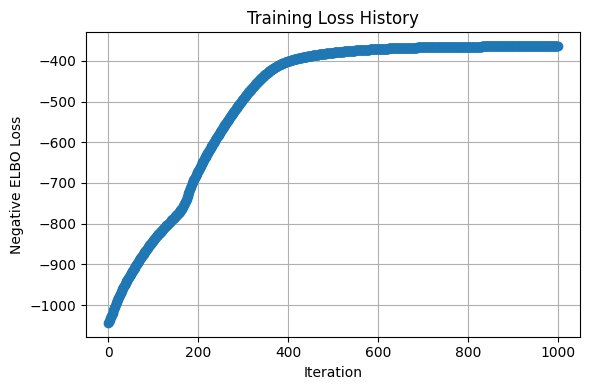

In [29]:
# --- Plot 1: ELBO (actually negative loss) over iterations ---
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Diffusion Kernel

In [18]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix)
likelihood = gpflow.likelihoods.MultiClass(num_classes=cls_number)

model = gpflow.models.SVGP(
    kernel=graph_kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=cls_number,
    whiten=True,
)

In [19]:
batch_size = 140 # full batch
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                         .shuffle(train_num).batch(batch_size).repeat()

opt = tf.optimizers.Adam(learning_rate=0.001)
num_steps = 5
loss_history = []

In [20]:
train_iter = iter(train_ds)  # endless iterator
pbar = tqdm(range(num_steps), desc="Training SVGP", unit="step")

for step in pbar:
    Xb, Yb = next(train_iter)
    with tf.GradientTape() as tape:
        loss = model.training_loss((Xb, Yb))   # negative ELBO
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    # record the ELBO (positive) rather than its negative
    elbo = -loss.numpy()
    loss_history.append(elbo)

    # update the bar with the latest loss
    pbar.set_postfix(loss=f"{elbo:.3e}")

Training SVGP:   0%|          | 0/5 [00:00<?, ?step/s]/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training SVGP: 100%|██████████| 5/5 [16:55<00:00, 203.02s/step, loss=-1.040e+03]


In [21]:
# 5. Evaluate
probs, _ = model.predict_y(x_test)
y_pred   = np.argmax(probs, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")

Test accuracy: 72.1%


In [22]:
print_summary(model)

╒═════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                            │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞═════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.beta                │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 2.0029                                               │
├─────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.sigma_f             │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 1.0016                             

## 3. GRF Kernel

### Choose a good number of walks per node $m$

In [ ]:
# MAX_WALK_LENGTH = 3
# walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024]
# grf_gram_matrices = []

# # beta_test = 0.1

# pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
#                                       max_walk_length=MAX_WALK_LENGTH,
#                                       normalize_laplacian=True) # note a random initialization of modulation function is used.


# gram_pofm = pofm_kernel.pofm_kernel(modulator_vector=learned_hyperparameters["modulator_vector"])

# for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
#     # Create the graph kernel with the current walk length
#     graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
#                                              walks_per_node=walks_per_node,
#                                              p_halt=0.1,
#                                              max_walk_length=MAX_WALK_LENGTH,
#                                              modulator_vector=learned_hyperparameters["modulator_vector"])
#     grf_gram_matrices.append(graph_kernel.grf_kernel(modulator_vector=learned_hyperparameters["modulator_vector"]))

Walk lengths: 100%|██████████| 11/11 [02:28<00:00, 13.53s/it]


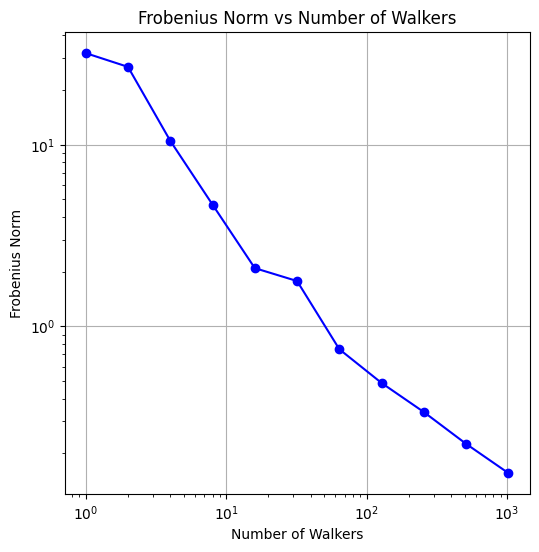

In [ ]:
# # Calculate Frobenius norms
# frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# # Plot Frobenius norm vs. Number of Walkers
# plt.figure(figsize=(6, 6))
# plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
# plt.xlabel('Number of Walkers')
# plt.xscale('log')
# plt.ylabel('Frobenius Norm')
# plt.yscale('log')
# plt.title('Frobenius Norm vs Number of Walkers')
# plt.grid(True)
# plt.show()

In [ ]:
# ensure the data directory exists
os.makedirs('./data', exist_ok=True)

# assume walks_per_nodes and frobenius_norms are already defined lists or arrays
walks = np.array(walks_per_nodes)
fros   = np.array(frobenius_norms)

# 1) Save as CSV
df = pd.DataFrame({
    'walks_per_node': walks,
    'frobenius_norm': fros
})
csv_path = './data/frobenius_norms.csv'
df.to_csv(csv_path, index=False)
print(f"Saved CSV to {csv_path}")

Saved CSV to ./data/frobenius_norms.csv


### Model Configuration

In [30]:
graph_kernel = GraphGeneralFastGRFKernel(
    adjacency_matrix,
    walks_per_node=4096,  # Use the last value from the list
    p_halt=0.1,
    max_walk_length=MAX_WALK_LENGTH,
    modulator_vector=learned_hyperparameters["modulator_vector"]
)
likelihood = gpflow.likelihoods.MultiClass(num_classes=cls_number)

model = gpflow.models.SVGP(
    kernel=graph_kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=cls_number,
    whiten=True,
)

Random walks: 100%|██████████| 2485/2485 [06:10<00:00,  6.71it/s]


In [31]:
batch_size = 140 # full batch
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                         .shuffle(train_num).batch(batch_size).repeat()

opt = tf.optimizers.Adam(learning_rate=0.003)
num_steps = 500
loss_history = []

In [32]:
train_iter = iter(train_ds)  # endless iterator
pbar = tqdm(range(num_steps), desc="Training SVGP", unit="step")

for step in pbar:
    Xb, Yb = next(train_iter)
    with tf.GradientTape() as tape:
        loss = model.training_loss((Xb, Yb))   # negative ELBO
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    # record the ELBO (positive) rather than its negative
    elbo = -loss.numpy()
    loss_history.append(elbo)

    # update the bar with the latest loss
    pbar.set_postfix(loss=f"{elbo:.3e}")

Training SVGP:   0%|          | 0/500 [00:00<?, ?step/s]/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training SVGP: 100%|██████████| 500/500 [17:58<00:00,  2.16s/step, loss=-3.882e+02]


In [33]:
# 5. Evaluate
probs, _ = model.predict_y(x_test)
y_pred   = np.argmax(probs, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")

Test accuracy: 70.5%


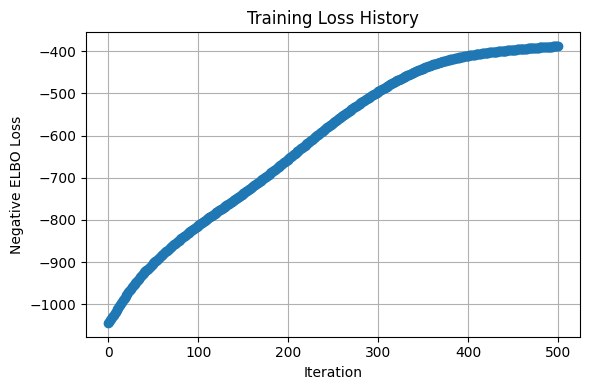

In [34]:
# --- Plot 1: ELBO (actually negative loss) over iterations ---
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.tight_layout()
plt.show()

## Matern Kernel: Accuracy 79.4%